# EndoSign: End-to-End Demo Analysis
*Demonstrates all core project functionality with example (dummy) data.*

---

In [1]:
import sys
import os

project_root = os.path.abspath("..")
if project_root not in sys.path:
    sys.path.insert(0, project_root)
    
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from endosign.data_loader import load_patient_data, validate_patient_data
from endosign.reporting import generate_profiling_report, generate_markdown_report, generate_text_report
from endosign.classification import train_and_evaluate_classifier
from endosign.preprocessing import (clean_data, fill_missing_biomarkers, log_transform_biomarkers,
                                    remove_biomarker_outliers, normalize_biomarkers, encode_rasrm_stage)
from endosign.visualization import (plot_group_counts, multiplot_biomarkers,plot_venn,multiplot_endo_class,
                                    plot_biomarker_heatmap, plot_biomarker_correlation,plot_dimensionality_reduction,multiplot_embedding)
from endosign.biomarkers import compare_biomarkers_statistical, find_candidate_biomarkers

from endosign.clustering import reduce_dimensions, cluster_patients




/home/codespace/.python/current/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load the example data
df = load_patient_data("../data/example/dummy_data.csv")
assert validate_patient_data(df), "Data format error!"

# Show quick preview
print("Shape:", df.shape)
display(df.head())

Shape: (200, 52)


,Patient_ID,Group,Age,BMI,rASRM_stage,Leiomyoma,Enzian_P,Enzian_O,Enzian_T,Enzian_A,...,Cytokine_27,Cytokine_28,Cytokine_29,Cytokine_30,Cytokine_31,Cytokine_32,Cytokine_33,Cytokine_34,Cytokine_35,Cytokine_36
0,P001,Endometriosis,42,26.1,III,Yes,2,2,3,2,...,6.84,4.42,5.53,5.64,3.66,6.98,4.65,3.49,6.07,3.20
1,P002,Control,38,20.5,NaN,No,0,0,0,0,...,4.57,7.98,5.30,4.33,3.77,4.40,4.22,5.34,5.32,5.01
2,P003,Endometriosis,29,26.4,II,Yes,3,1,1,1,...,4.11,3.23,4.65,8.42,2.26,1.77,7.94,4.58,3.66,7.08
3,P004,Endometriosis,35,26.1,IV,Yes,1,0,2,0,...,6.99,3.49,2.16,8.00,4.35,4.50,7.66,6.11,5.91,9.33
4,P005,Endometriosis,26,21.6,III,Yes,2,0,2,3,...,6.33,7.35,5.36,2.41,5.80,3.70,3.94,6.17,7.48,5.04


In [3]:
biomarker_cols = [col for col in df.columns if col.startswith("Cytokine_")]

df = clean_data(df)
df = fill_missing_biomarkers(df, biomarker_cols)
df = log_transform_biomarkers(df, biomarker_cols)
df = remove_biomarker_outliers(df, biomarker_cols)
df = normalize_biomarkers(df, biomarker_cols)
df = encode_rasrm_stage(df)

/workspaces/EndoSign/endosign/visualization.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=group_col, data=df, ax=ax, palette="muted")


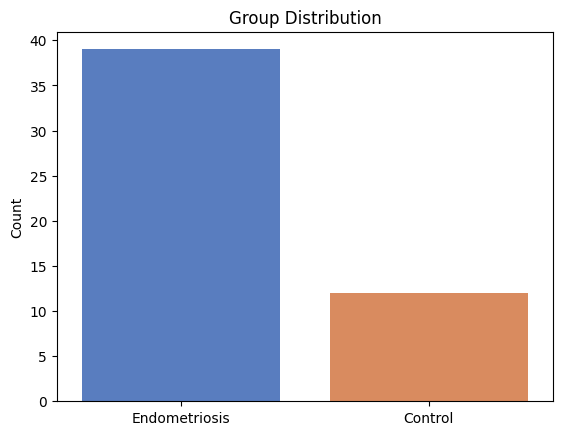

In [4]:
plot_group_counts(df)

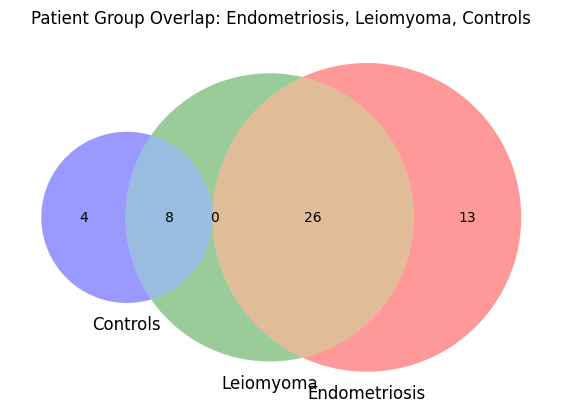

In [5]:
plot_venn(df)

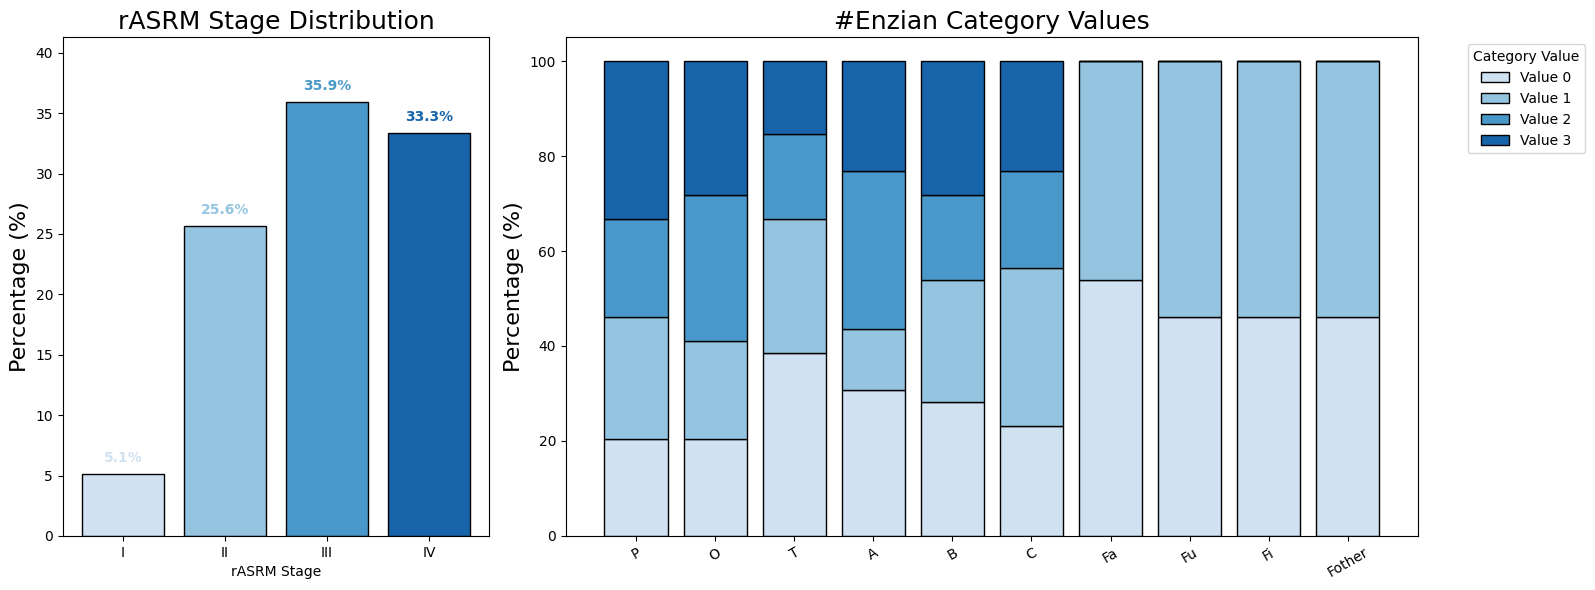

In [6]:
multiplot_endo_class(df)

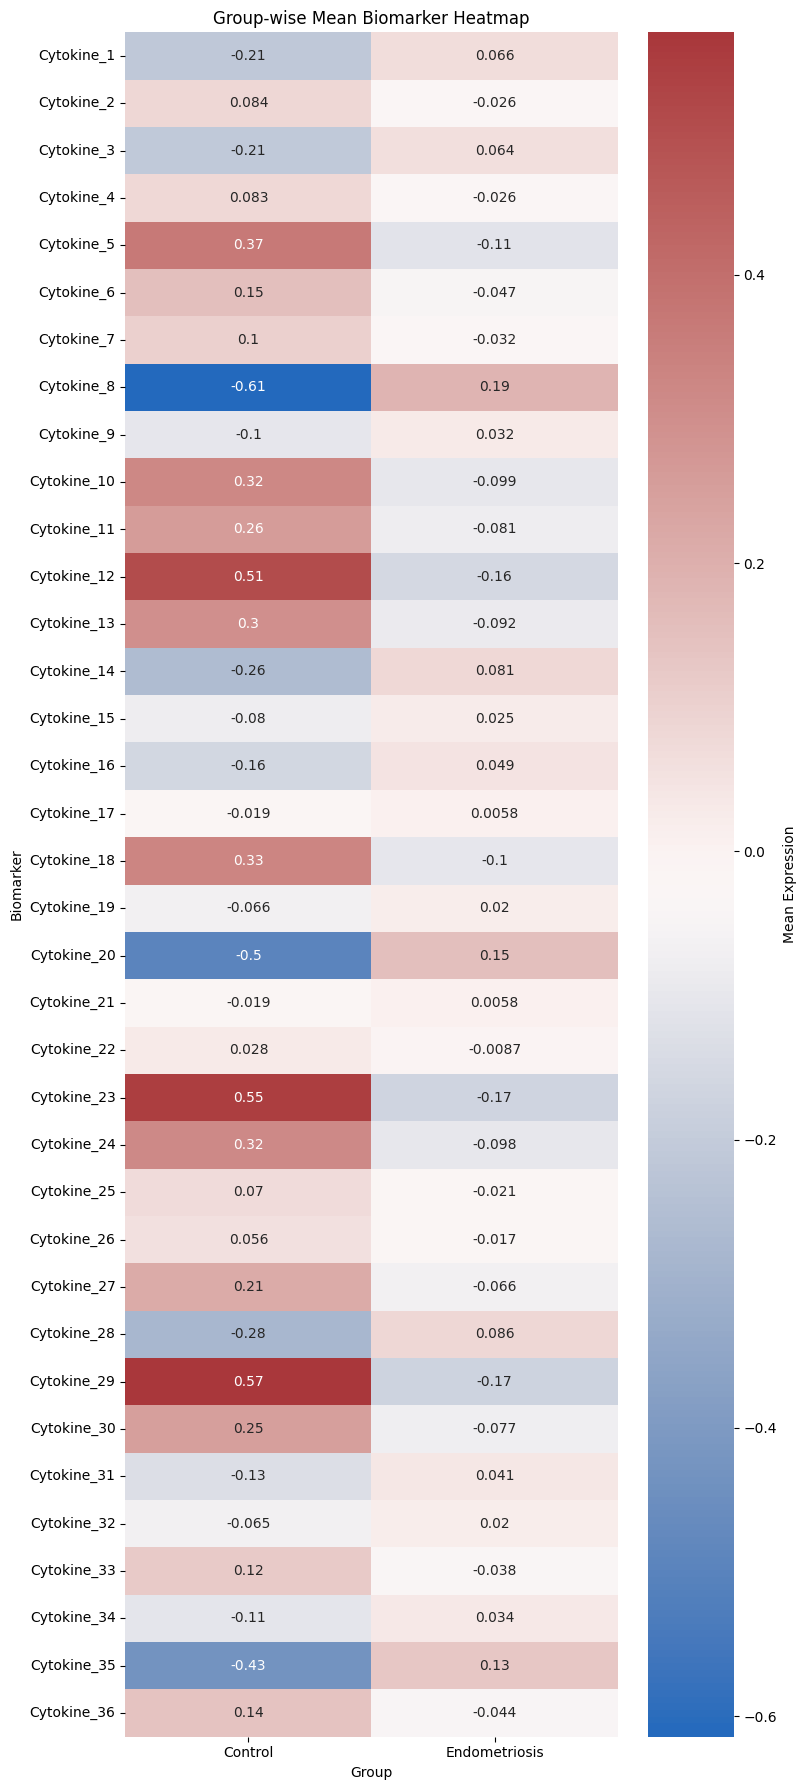

In [7]:
plot_biomarker_heatmap(df, biomarker_cols, by_group_mean=True)

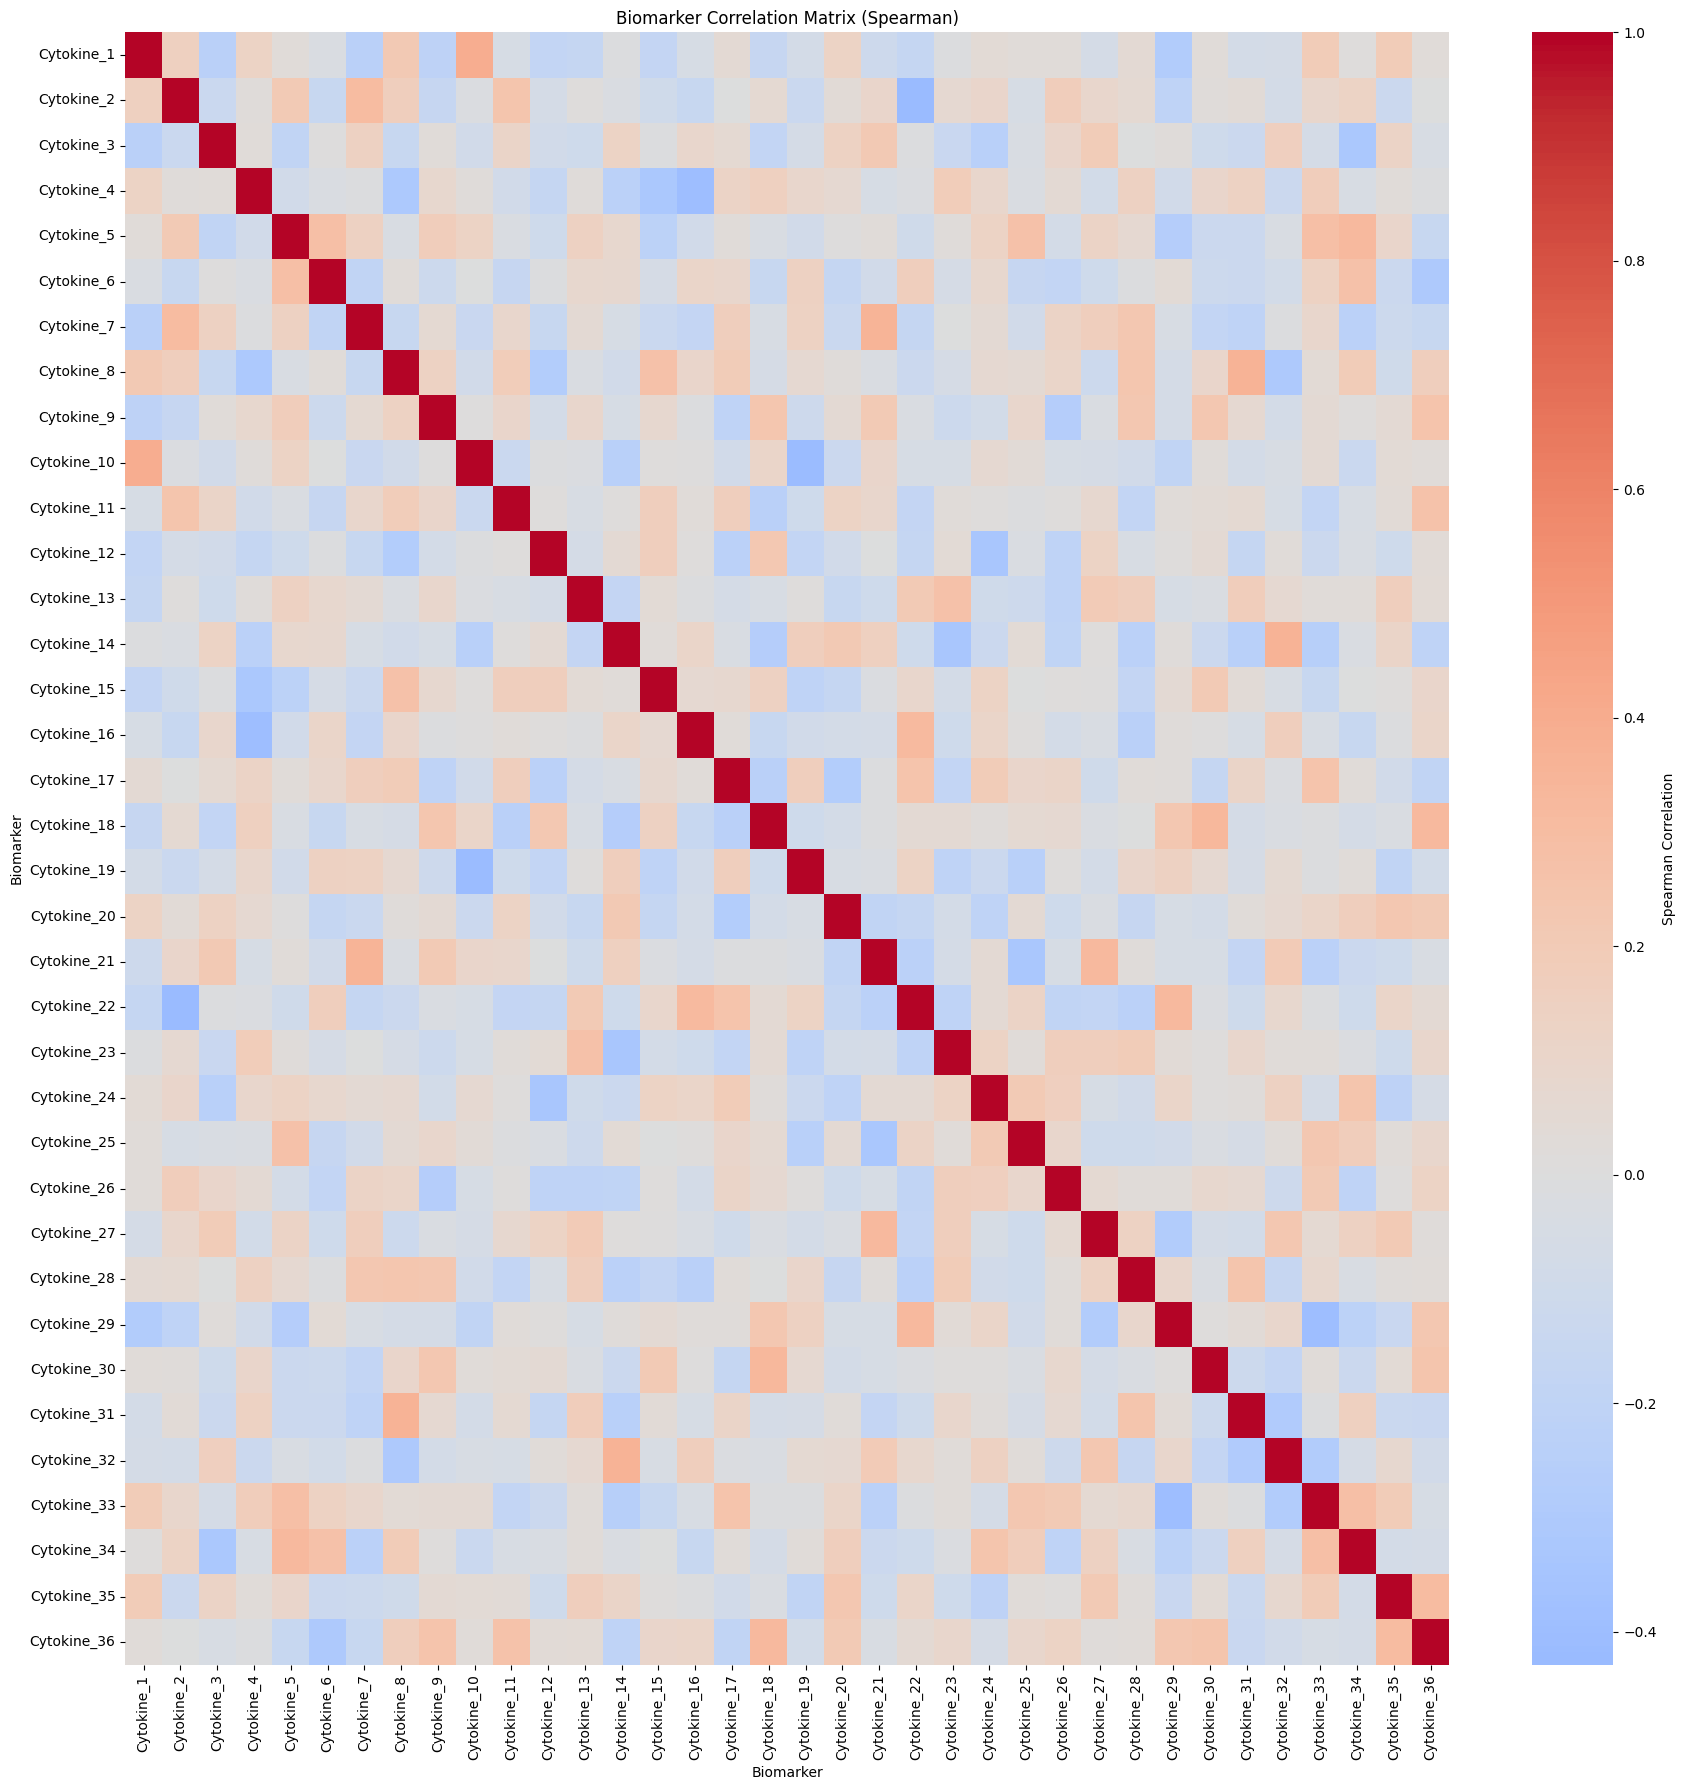

In [8]:
plot_biomarker_correlation(df, biomarker_cols, method="spearman", annot=False)

/home/codespace/.python/current/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


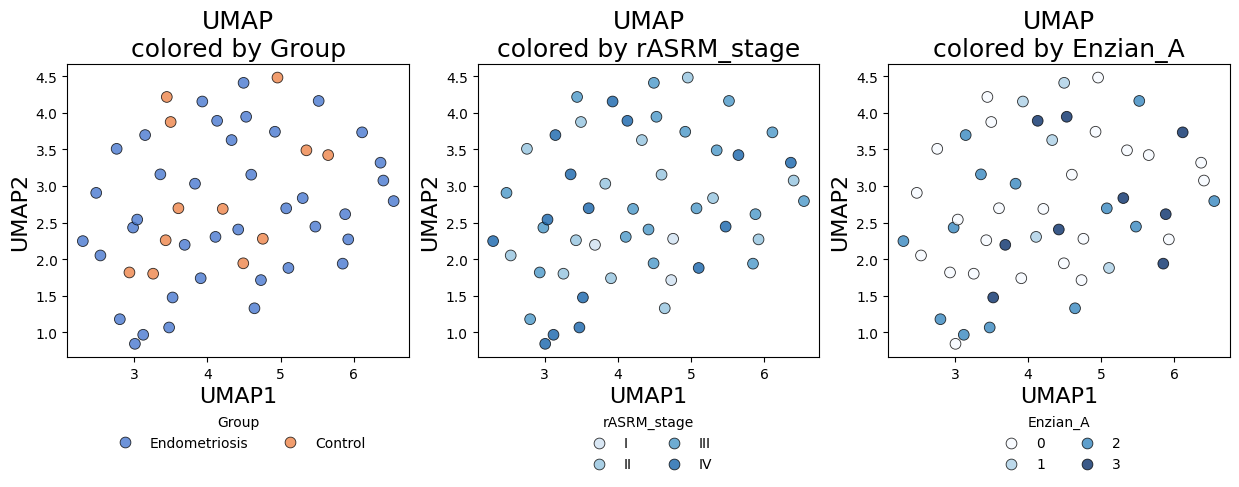

In [9]:
biomarker_cols = [col for col in df.columns if col.startswith("Cytokine_")]
plot_dimensionality_reduction(
    df, biomarker_cols, 
    method='umap', 
    color_by=['Group', 'rASRM_stage', 'Enzian_A']
)

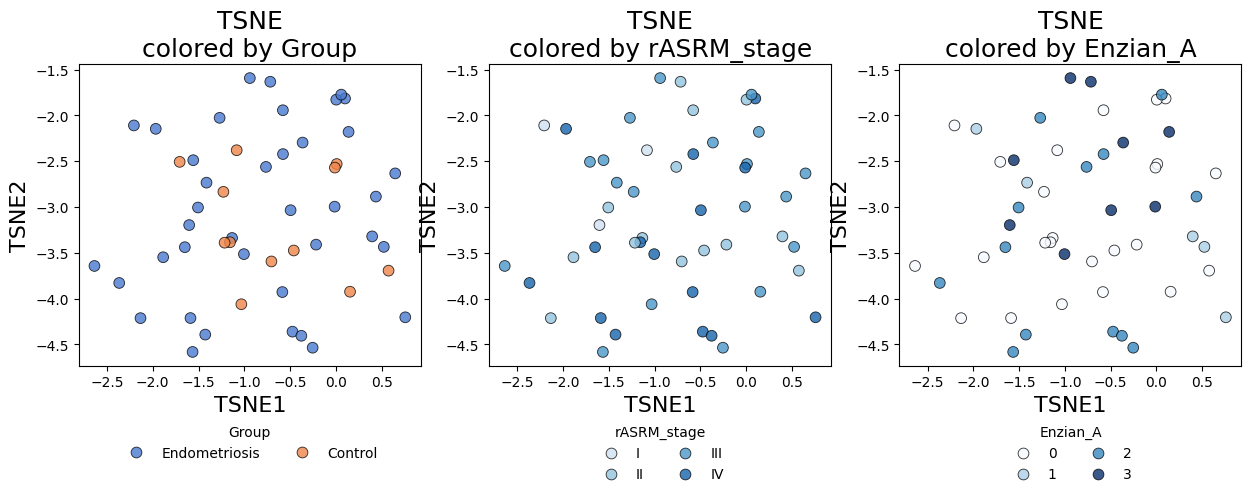

In [10]:
plot_dimensionality_reduction(
    df, biomarker_cols, 
    method='tsne', 
    color_by=['Group', 'rASRM_stage', 'Enzian_A']
)


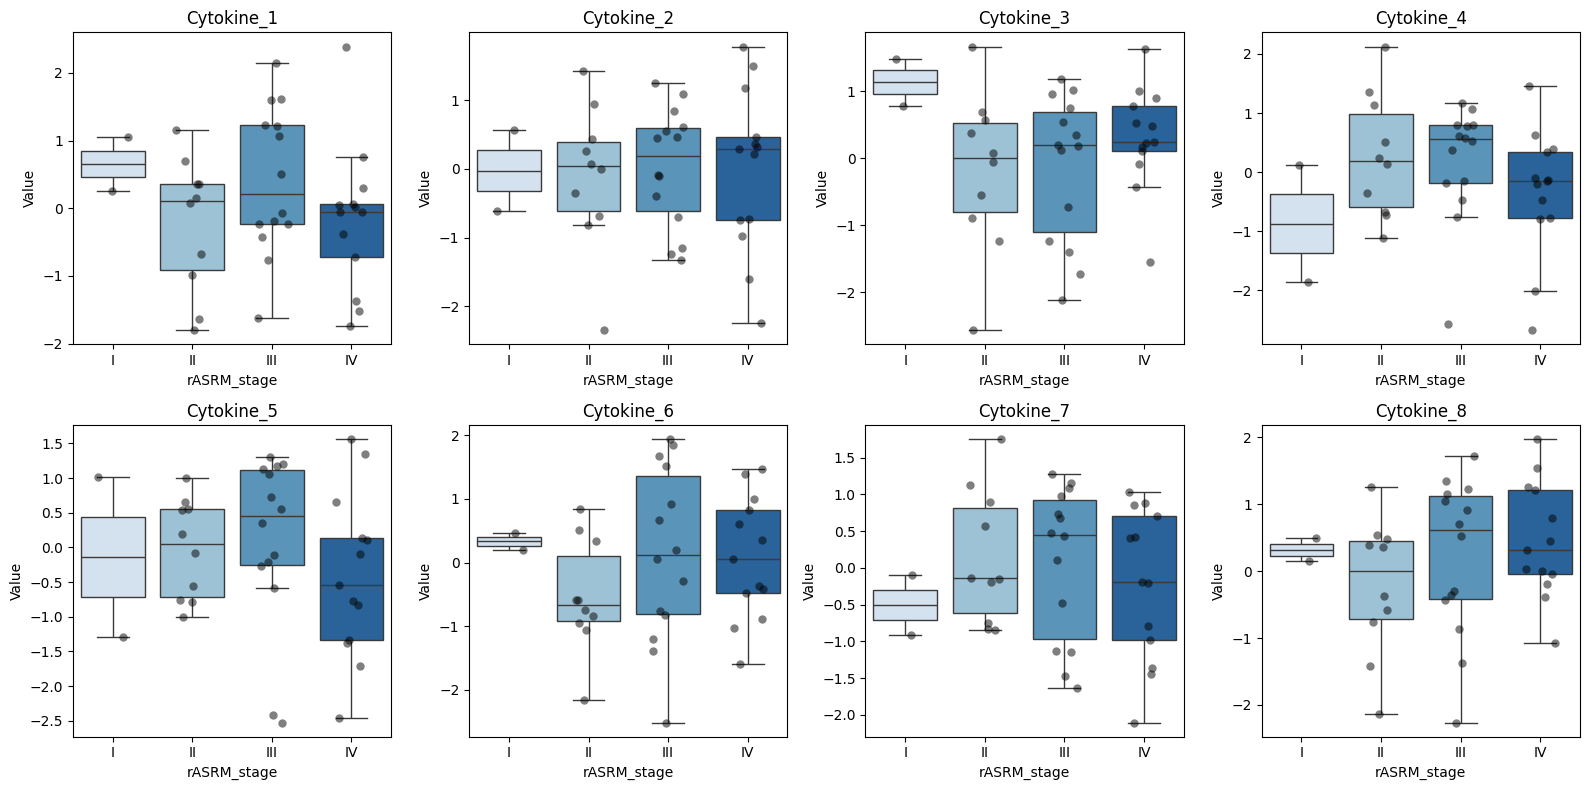

In [11]:
multiplot_biomarkers(
    df, biomarker_cols[:8],
    group_by='rASRM_stage',
    group_order=['I', 'II', 'III', 'IV'],
    palette='Blues_r',
    subset_condition=lambda d: d['Group'] == 'Endometriosis',
    jitter=0.2,
    alpha=0.5,
    marker_size=6
)


/home/codespace/.python/current/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/codespace/.python/current/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


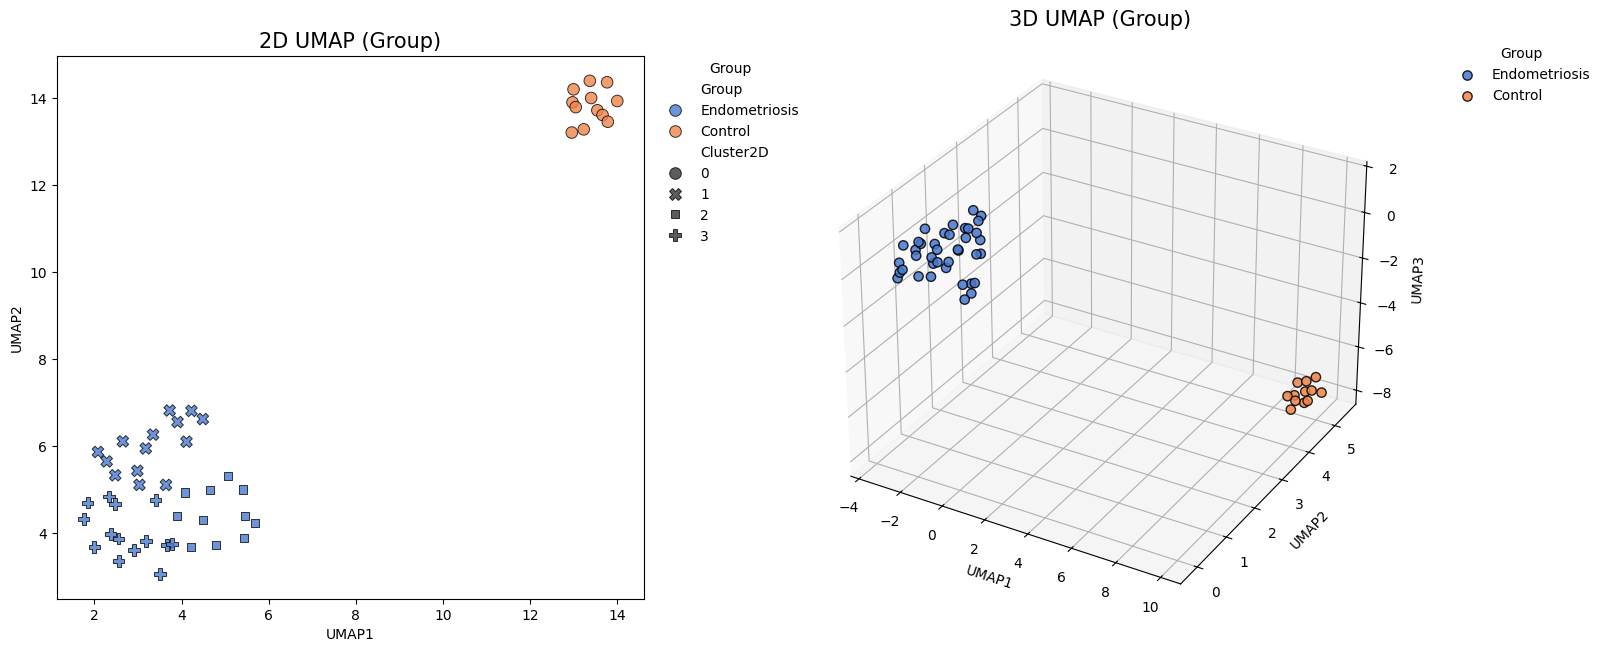

In [12]:
# --- 1. Select Enzian Feature Columns (all patients, no filtering) ---
enzian_cols = [col for col in df.columns if col.startswith("Enzian_")]
X_enz = df[enzian_cols]

# --- 2. Compute 2D and 3D UMAP Embeddings ---
from endosign.clustering import reduce_dimensions

embedding_2d = reduce_dimensions(X_enz, method='umap', n_components=2)
embedding_3d = reduce_dimensions(X_enz, method='umap', n_components=3)

# --- 3. Assign Cluster Labels (on embedding, optional) ---
from endosign.clustering import cluster_patients

df['Cluster2D'] = cluster_patients(embedding_2d, method='kmeans', n_clusters=4)
df['Cluster3D'] = cluster_patients(embedding_3d, method='kmeans', n_clusters=4)

# --- 4. Visualization: 2D and 3D Multiplot ---
from endosign.visualization import multiplot_embedding

multiplot_embedding(
    df, embedding_2d, embedding_3d,
    color_by='Group',         # or 'Cluster2D', 'Cluster3D', etc.
    cluster_col='Cluster2D'   # for style/shapes; can be None
)

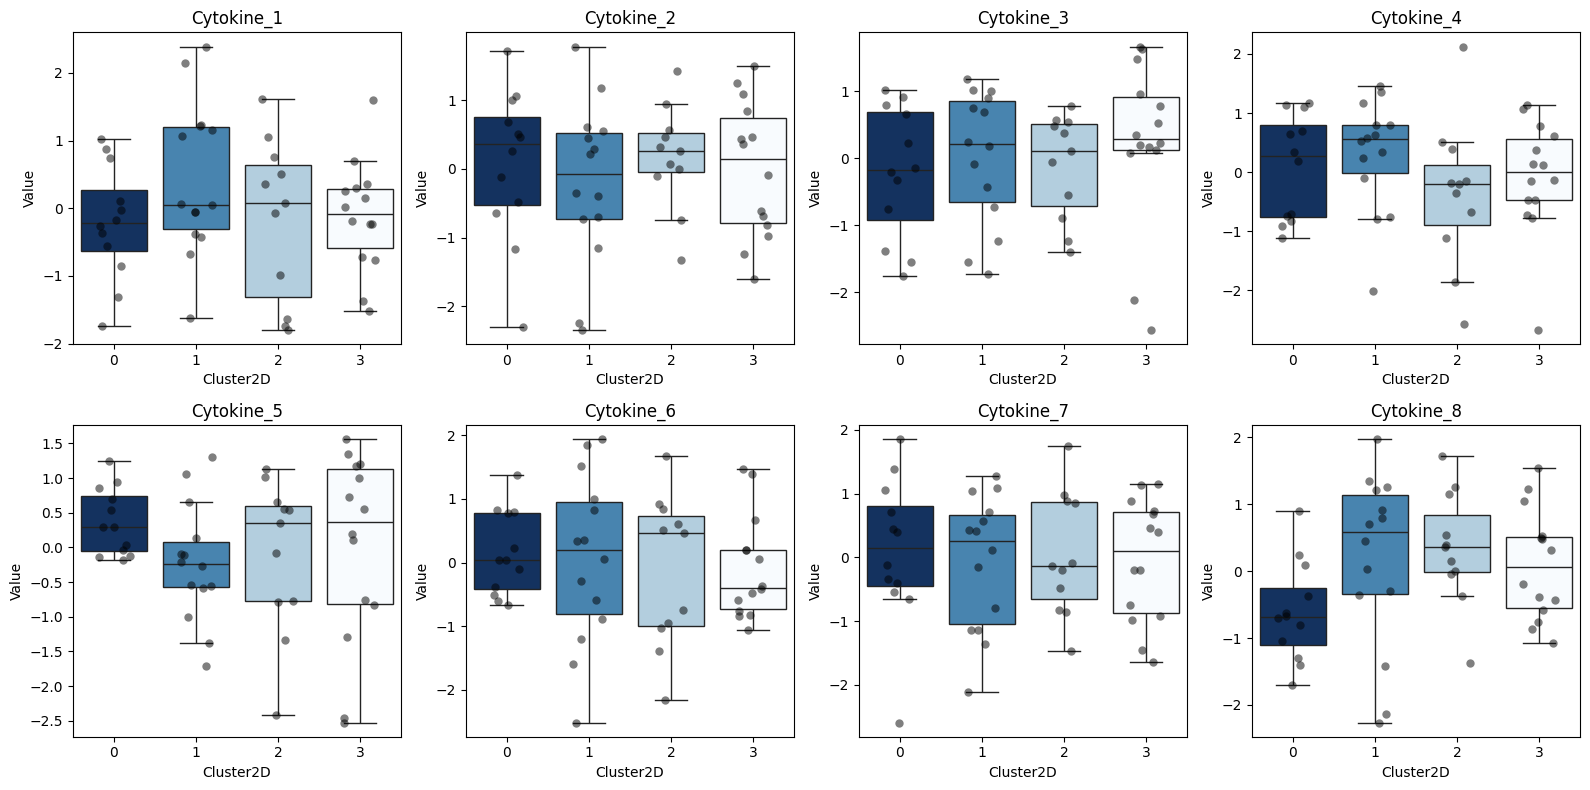

In [18]:
multiplot_biomarkers(
    df, biomarker_cols[:8],
    group_by='Cluster2D',
    group_order=['0', '1', '2', '3'],
    palette='Blues_r',
    jitter=0.2,
    alpha=0.5,
    marker_size=6
)


In [13]:
stats_df = compare_biomarkers_statistical(df, biomarker_cols)
candidates = find_candidate_biomarkers(stats_df, p_thresh=0.01, effect_thresh=1.0)
print("Candidate biomarkers:", candidates)


Candidate biomarkers: []


In [14]:
model, report = train_and_evaluate_classifier(
    df, biomarker_cols, target_col="Group", model_name="random_forest"
)
print(report)

{'Control': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 3.0}, 'Endometriosis': {'precision': 0.7272727272727273, 'recall': 1.0, 'f1-score': 0.8421052631578947, 'support': 8.0}, 'accuracy': 0.7272727272727273, 'macro avg': {'precision': 0.36363636363636365, 'recall': 0.5, 'f1-score': 0.42105263157894735, 'support': 11.0}, 'weighted avg': {'precision': 0.5289256198347108, 'recall': 0.7272727272727273, 'f1-score': 0.6124401913875598, 'support': 11.0}}


/home/codespace/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/codespace/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/codespace/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [15]:
# generate_profiling_report(df)  # Output: outputs/profiling_report.html